## PCB Images Training & Testing

### 1. Load the relevant libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
print(tf.__version__)

2.10.0


### 2. Load training set

In [4]:
training_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/data/PCB/Training_Dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    seed=123,
    image_size=(110, 42),
    shuffle=True,
    validation_split = 0.2,
    subset="training"
)

Found 12000 files belonging to 8 classes.
Using 9600 files for training.


### 3. Perform validity checks

In [5]:
class_names = training_set.class_names
print(class_names)
data_iterator = training_set.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0].shape)
batch[1]

['0', '1', '2', '3', '4', '5', '6', '7']
(32, 110, 42, 3)


array([0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 4, 3, 0, 1, 0, 1, 0, 0, 4])

### 4. Plot some images

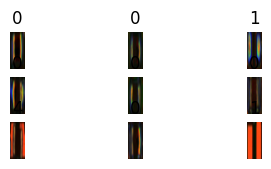

In [6]:
plt.figure(figsize=(110/25.4, 42/25.4))
for images, labels in training_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### 5. Standardize data

In [7]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = training_set.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.8446448


In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_set = training_set.cache().prefetch(buffer_size=AUTOTUNE)

### 6. DEFINE the model

In [9]:
num_classes = 8
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [10]:
model.compile(
  optimizer = 'adam',
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics = ['accuracy'])

### 7. Validation Data

In [11]:
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/data/PCB/Training_Dataset',
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=32,
    seed=123,
    image_size=(110, 42),
    shuffle=True,
    validation_split = 0.2,
    subset="validation"
)

Found 12000 files belonging to 8 classes.
Using 2400 files for validation.


### 8. Fit the model

In [12]:
history = model.fit(
  training_set,
  validation_data = validation_set,
  epochs=3
)

Epoch 1/3
300/300 [==============================] - 46s 151ms/step - loss: 0.4913 - accuracy: 0.8473 - val_loss: 0.2605 - val_accuracy: 0.9192
Epoch 2/3
300/300 [==============================] - 36s 121ms/step - loss: 0.1918 - accuracy: 0.9378 - val_loss: 0.1676 - val_accuracy: 0.9475
Epoch 3/3
300/300 [==============================] - 36s 121ms/step - loss: 0.1406 - accuracy: 0.9549 - val_loss: 0.1428 - val_accuracy: 0.9558


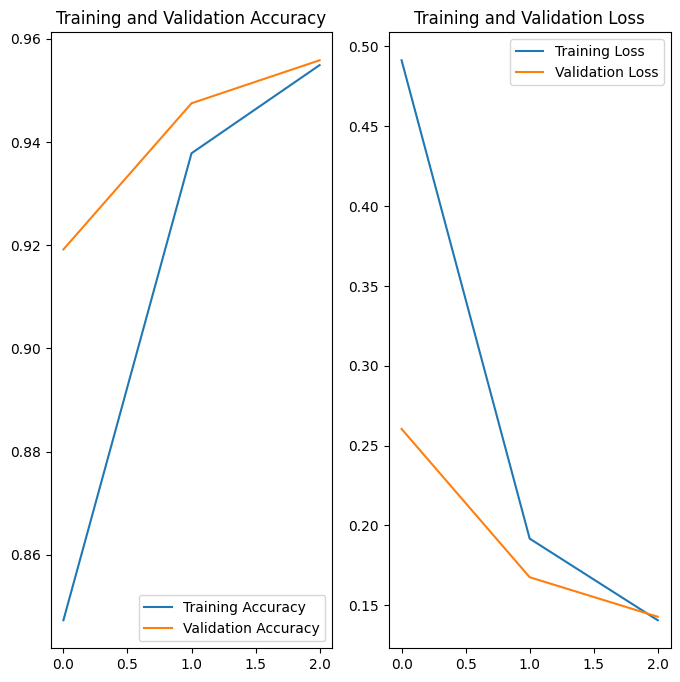

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 9. Predict from Evaluation Data

In [28]:
import cv2
import matplotlib.image as pmg

In [46]:
test_path = "D:/data/PCB/Evaluation_Dataset"
x_test = []
pred_test = []
for filename in os.listdir(test_path):
    img = pmg.imread(os.path.join(test_path, filename))
    h, w, c = img.shape
    img.shape = w, h, c
    img = img.reshape(-1, w, h, c)        
    x_test.append(img)

In [48]:
x_test = np.array(x_test)
print(x_test.shape)

(200, 1, 110, 42, 3)


In [52]:
y_test = np.array(class_names)
print(y_test)
y_test = y_test.reshape(-1, 1)
print(y_test.shape)

['0' '1' '2' '3' '4' '5' '6' '7']
(8, 1)


In [53]:
model.evaluate(x_test, y_test, batch_size=32)

ValueError: Data cardinality is ambiguous:
  x sizes: 200
  y sizes: 8
Make sure all arrays contain the same number of samples.

In [45]:
test_path_image1 = "D:/data/PCB/Evaluation_Dataset/20190815163809_R171.png"
img = pmg.imread(test_path_image1)
h, w, c = img.shape
img.shape = w, h, c
img = img.reshape(-1, w, h, c)        
cls = model.predict(img)
print(f"predict: {cls}")
print(f"classes: {class_names}")
#print(f"probability: {probs}")

1/1 [==============================] - 0s 35ms/step
predict: [[ 1.8494177  -2.317564   -0.93409395  1.5613062   0.20960382  0.24209088
   1.4558146   0.92355263]]
classes: ['0', '1', '2', '3', '4', '5', '6', '7']


1/1 [==============================] - 0s 34ms/step


ValueError: not enough values to unpack (expected 2, got 1)

### 10. Write output to Text file

In [41]:
with open('class_output.txt', 'w') as f:    
    f.write("Image .....................................Probability")
    f.write('\n')
    for val in range(len(pred_test)):
        f.write(str(pred_test[val]))
        f.write('\n')
    